In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
x = np.arange(0, 10)
y = np.exp(-x/3.0)
f = interpolate.interp1d(x, y)

In [5]:
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [4]:
y

array([1.        , 0.71653131, 0.51341712, 0.36787944, 0.26359714,
       0.1888756 , 0.13533528, 0.09697197, 0.06948345, 0.04978707])

In [7]:
f(0.5)

array(0.85826566)

In [11]:
type(f)

scipy.interpolate._interpolate.interp1d

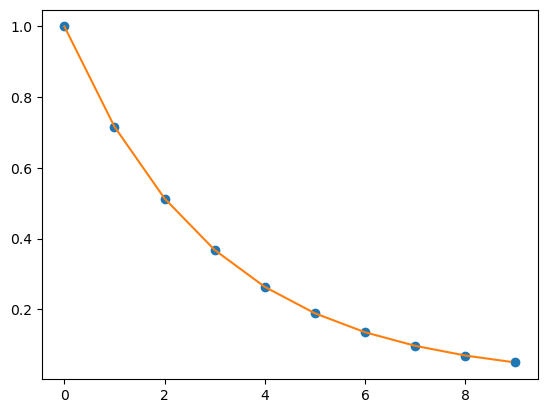

In [3]:
xnew = np.arange(0, 9, 0.1)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o', xnew, ynew, '-')
plt.show()

Mudando o código: 
    

In [13]:
import numbers
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp
from get_data import get_weather_data 
from parameters import dict_d, dict_mu_a, dict_mu_m, dict_gamma_m, dict_theta_m
from edo_model_yang import get_temp

In [14]:
def system_odes(t,x, param_fit, param_fixed, temp, cap, fixed = True):
    '''
    Função que implementa o sistema de equações. 
    :params param_fit: tuple. parâmetros que serão fitados. 
    :params param_fixed: tuple. parâmetros que serão fixados. 
    :params temp: array. Array com os valores de temperatura. O tamanho desse array deve ser 
                        condizente com o intervalo de tempo que o modelo será integrado. 
    :params cap: float or array. Parametro que irá determinar a cap suporte do modelo. 
    :params fixed: boolean. Se True serão usados os parâmetros ontomológicos fixos. 
    '''

    #definindo parâmetros que vão ser fitados
    b, beta = param_fit 

    beta_m = beta
    beta_h = beta

    MU_H, THETA_H, ALPHA_H, K, C_A, C_M, D = param_fixed

    #Colocando cada variável em uma posição:
    A  = x[0] #Aquatic mosquito population
    Ms = x[1] #Susceptible mosquitos population
    Me = x[2] #Exposed mosquitos population (infected but not infectious)
    Mi = x[3] #Infectious mosquitos population
    Hs = x[4] #Susceptible human population
    He = x[5] #Exposed human population
    Hi = x[6] #Infectious human population
    Hr = x[7] #Recovered Individuals


    #Definindo condições de contorno para as variáveis(?):
    M = A+Ms+Me+Mi  #População total de Mosquitos
    H = Hs+He+Hi+Hr #População total de humanos
    
    #Definindo cada ODE:
    dA_dt  = K*d(t,temp, fixed)*(1-(A/C(t, D, cap)))*M - (gamma_m(t,temp, fixed) + mu_a(t,temp, fixed) + C_A)*A
    dMs_dt = gamma_m(t,temp, fixed)*A - (b*beta_m*Ms*Hi)/H - (mu_m(t,temp, fixed) + C_M)*Ms
    dMe_dt = (b*beta_m*Ms*Hi)/H - (theta_m(t,temp, fixed ) + mu_m(t,temp, fixed) + C_M)*Me
    dMi_dt = theta_m(t,temp, fixed)*Me - (mu_m(t,temp, fixed) + C_M)*Mi
    dHs_dt = MU_H*(H-Hs) - (b*beta_h*Hs*Mi)/H
    dHe_dt = (b*beta_h*Hs*Mi)/H - (THETA_H + MU_H)*He
    dHi_dt = THETA_H*He - (ALPHA_H + MU_H)*Hi
    dHr_dt = ALPHA_H*Hi - MU_H*Hr

    return [dA_dt, dMs_dt, dMe_dt, dMi_dt, dHs_dt, dHe_dt, dHi_dt, dHr_dt]

In [15]:
T1 = get_temp(start_date = '2010-01-08', end_date = '2010-07-01')

T1

array([28. , 27.6, 26.1, 26.8, 25.1, 25. , 25.2, 23.7, 26.5, 26.6, 27. ,
       27.2, 23.2, 23.7, 24.4, 26.1, 27. , 25.1, 25.4, 25.9, 24.2, 26.6,
       27.9, 28. , 27.9, 29.4, 30.6, 29.2, 30.6, 28.5, 30. , 25.6, 24.1,
       27.3, 27.5, 27.4, 25.5, 24.6, 24.4, 22.8, 25.4, 27.5, 28.5, 28.8,
       27.9, 26.5, 28. , 23.5, 23.5, 24.8, 22.3, 24.5, 26.1, 25.7, 25.9,
       26.4, 25.8, 24.4, 24. , 24.1, 25.7, 26.9, 25.5, 26.2, 25.4, 25.4,
       24.9, 25.8, 26.8, 27.1, 27.8, 25. , 24.9, 23.3, 22.8, 22.4, 24.4,
       25.1, 24.9, 24.9, 25.4, 25.2, 25.7, 26.7, 26. , 25.5, 23.4, 19. ,
       19.1, 18.9, 19.5, 19.6, 20.2, 20.9, 21.6, 23.2, 23.4, 21.5, 22.7,
       25.3, 26.5, 25.5, 26.4, 24.6, 23.5, 18.7, 17.8, 22.3, 20.2, 18.1,
       19.5, 20. , 19.4, 19.6, 21.7, 22.1, 18.6, 18.8, 22. , 20.2, 16.3,
       13.6, 14.2, 13. , 13. , 15.9, 19.2, 20.5, 18. , 19.1, 12.8, 13.7,
       15.2, 16.7, 19.9, 21.4, 20.1, 17.1, 17.4, 18.5, 18.4, 20.3, 17.4,
       13.5, 13. , 16.2, 17.8, 17.6, 14.4, 11.8, 13

In [33]:
def interpolate_params(temp, dict_values): 

    '''
    Função que retorna uma função que relacionado cada instante de tempo t com um 
    valor salvo em dict_values. 
    
    A partir dos valores de temperatura em temp encontramos os respectivos valores
    do parâmetro e a partir deles usamos o método  interpolate.interp1d() para encontrar
    o valor do parâmetro para cada instante t. Fazemos isso para evitar descontinuidades
    na integração do modelo. 
    
    :params temp: array. Array com as temperaturas para os respectivos dias.
    :params dict_values: dictionary. As "chaves" são os valores de temperatura e os "valores" é o valor do 
    parâmetro associado com esssa temperatura. 
    
    :returns: scipy.interpolate._interpolate.interp1d. 
    ''' 
    
    values = np.array([dict_gamma_m[T] for T in temp])
    
    dias = np.arange(0, len(temp))
  
    f = interpolate.interp1d(dias, values)

    return f

In [35]:
f = gamma_m(T1)

f(0)

array(0.12013992)

In [37]:
type(f)

scipy.interpolate._interpolate.interp1d

In [36]:
f(0.5)

array(0.11786785)

In [27]:
print(len(gamma_m(T1)))
print(len(gamma_m_2(T1)))

175
175


In [31]:
%%time
s = gamma_m(T1)

CPU times: user 120 µs, sys: 1 µs, total: 121 µs
Wall time: 129 µs


In [32]:
%%time 
s = gamma_m_2(T1)

CPU times: user 73 µs, sys: 1e+03 ns, total: 74 µs
Wall time: 78.9 µs


In [29]:
np.array(gamma_m(T1)) - np.array(gamma_m_2(T1))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [23]:
dict_gamma_m[list(T1)]

TypeError: unhashable type: 'list'

In [18]:
gamma_m(T1)

[0.1201399243664154,
 0.1155957691884923,
 0.1000717121753842,
 0.1069736843649318,
 0.0914424348292461,
 0.0906642051372665,
 0.0922363110799109,
 0.081959911562838,
 0.1039349916145129,
 0.1049349167551012,
 0.1090621614098852,
 0.1111974822907102,
 0.0792783453912369,
 0.081959911562838,
 0.0863237774656591,
 0.1000717121753842,
 0.1090621614098852,
 0.0914424348292461,
 0.0938707986356233,
 0.0982253824563654,
 0.0850013744787352,
 0.1049349167551012,
 0.1189919469366858,
 0.1201399243664154,
 0.1189919469366858,
 0.1366730640743201,
 0.15050844722749,
 0.1342930418886014,
 0.15050844722749,
 0.125974268029835,
 0.1437280299650689,
 0.0955670805642912,
 0.0843631286148438,
 0.1122817357962011,
 0.1144813264434079,
 0.1133764966132586,
 0.0947112631306454,
 0.0877080630772484,
 0.0863237774656591,
 0.0773710972206433,
 0.0938707986356233,
 0.1144813264434079,
 0.125974268029835,
 0.1295285732039799,
 0.1189919469366858,
 0.1039349916145129,
 0.1201399243664154,
 0.0808456395128898,
